In [98]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio

In [99]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Controls/201908_fixedctrltnr647/' #master folder
protein="WFA" #TNR,Agg,WFA,HABP

In [100]:
results = {"filename":[],"exp":[],
           "Manual mask from matlab GUI":[],
           "intensity":[],"int under mask":[],"bg sub int under mask":[],"bg sub int unmasked":[]}

histogram_results={"filename":[],"exp condition":[],
                   "ECM raw intensity- Flattened histogram":[],
                   "Nuclei raw intensity- Flattened histogram":[],
                   "Synapse raw intensity- Flattened histogram":[]}
regionprops_results={"filename":[],
                     "exp condition":[],
                     "Synapse colour - regionprops soma":[],
                     "Synapse colour - regionprops neurites":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    #if "_analyse" in str(filelist[i]):
     #   if (protein in str(filelist[i]))==True:
            if ("TTX" in str(filelist[i]))==False:
                if filelist[i].endswith(".nd2"): 
                    results["filename"].append(filelist[i])
                    results["exp"].append(filelist[i].split('/')[-2])

In [101]:
print("\n".join(list(sorted(set(results["exp"])))))

1_blocked_immediatetnr647
2_blocked_plus12htnr647
3_1_blockedatto647
3_2_blockedpluis12h_atto647
4_noblock_atto
6_noblock_tnr647
6_notblocked_tnr647


In [102]:
## matlab files
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_mask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


In [103]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    flag=False
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[0]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    
    ###################analyses for the raw images -before processing##############
    #preserve the raw images
    ecm_image_raw = deepcopy(ecm_image)
    
    #normalize intensity to value between 0 and 1 - also just to make them easier to work with
    #ecm_image=np.divide(ecm_image,16383.)
    
    #read masks
    
    matlab_mask=results["Manual mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    
    #images after background subtraction
    #for ecm image
    bg_somamask=np.mean(ndi.median_filter(ecm_image,size=5))+0*np.std(ndi.median_filter(ecm_image,size=5))
    ecm__bgreduced=deepcopy(ecm_image_raw)
    ecm__bgreduced=np.subtract(ecm__bgreduced,bg_somamask)
    ecm__bgreduced[ecm__bgreduced<0]=0
    
    if flag==True:
        ecm_matlabmasked_bgreduced=deepcopy(ecm_image)


        bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
    
        
    results["intensity"].append(ecm_image_raw.mean())
    results["bg sub int unmasked"].append(ecm__bgreduced.mean())
    if flag==True:
        results["int under mask"].append(ecm_image_raw[matlab_mask].mean())
        results["bg sub int under mask"].append(ecm_matlabmasked_bgreduced[matlab_mask].mean())
    else:
        results["int under mask"].append(np.nan)
        results["bg sub int under mask"].append(np.nan)

Total number of images: 182
Calculating image no 1 out of182
Calculating image no 2 out of182
Calculating image no 3 out of182
Calculating image no 4 out of182
Calculating image no 5 out of182
Calculating image no 6 out of182
Calculating image no 7 out of182
Calculating image no 8 out of182
Calculating image no 9 out of182
Calculating image no 10 out of182
Calculating image no 11 out of182
Calculating image no 12 out of182
Calculating image no 13 out of182
Calculating image no 14 out of182
Calculating image no 15 out of182
Calculating image no 16 out of182
Calculating image no 17 out of182
Calculating image no 18 out of182
Calculating image no 19 out of182
Calculating image no 20 out of182
Calculating image no 21 out of182
Calculating image no 22 out of182
Calculating image no 23 out of182
Calculating image no 24 out of182
Calculating image no 25 out of182
Calculating image no 26 out of182
Calculating image no 27 out of182
Calculating image no 28 out of182
Calculating image no 29 out o

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountere

Calculating image no 40 out of182
Calculating image no 41 out of182
Calculating image no 42 out of182
Calculating image no 43 out of182
Calculating image no 44 out of182
Calculating image no 45 out of182
Calculating image no 46 out of182
Calculating image no 47 out of182
Calculating image no 48 out of182
Calculating image no 49 out of182
Calculating image no 50 out of182
Calculating image no 51 out of182
Calculating image no 52 out of182
Calculating image no 53 out of182
Calculating image no 54 out of182
Calculating image no 55 out of182
Calculating image no 56 out of182
Calculating image no 57 out of182
Calculating image no 58 out of182
Calculating image no 59 out of182
Calculating image no 60 out of182
Calculating image no 61 out of182
Calculating image no 62 out of182
Calculating image no 63 out of182
Calculating image no 64 out of182
Calculating image no 65 out of182
Calculating image no 66 out of182
Calculating image no 67 out of182
Calculating image no 68 out of182
Calculating im

In [104]:
df=pd.DataFrame(results)

In [105]:
df.columns

Index(['filename', 'exp', 'Manual mask from matlab GUI', 'intensity',
       'int under mask', 'bg sub int under mask', 'bg sub int unmasked'],
      dtype='object')

In [106]:
df2=deepcopy(df)
df2['Blocked or not']='None'
df2.loc[df2['exp'].str.contains('Blocked'), 'Blocked or not'] = 'Blocked'
df2.loc[df2['exp'].str.contains('no'), 'Blocked or not'] = 'Unblocked'

df2['Time']='Immediately'

df2['TNR or secondary']='None'
df2.loc[df2['exp'].str.contains('tnr'), 'TNR or secondary'] = 'TNR'
df2.loc[df2['exp'].str.contains('tnr'), 'TNR or secondary'] = 'TNR'

df2['expno']='None'
df2.loc[df2['filename'].str.contains('exp1'), 'expno'] = 'exp1'
df2.loc[df2['filename'].str.contains('exp2'), 'expno'] = 'exp2'
df2.loc[df2['filename'].str.contains('exp3'), 'expno'] = 'exp3'

df2["Condition"]='None'
df2.loc[df2['filename'].str.contains('1_blocked_immediatetnr647'), 'Condition'] = 'Block+0, TNR647'
df2.loc[df2['filename'].str.contains('3_1_blockedatto647'), 'Condition'] = 'Block+0, mouseAtto647'
df2.loc[df2['filename'].str.contains('2_blocked_plus12htnr647'), 'Condition'] = 'Block+12, TNR647'
df2.loc[df2['filename'].str.contains('3_2_blockedpluis12h_atto647'), 'Condition'] = 'Block+12, mouseAtto647'

df2.loc[df2['filename'].str.contains('6_notblocked_tnr647'), 'Condition'] = 'Unblocked TNR647'
df2.loc[df2['filename'].str.contains('6_noblock_tnr647'), 'Condition'] = 'Unblocked TNR647'
df2.loc[df2['filename'].str.contains('4_noblock_atto'), 'Condition'] = 'Unblocked mouseAtto647'



(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

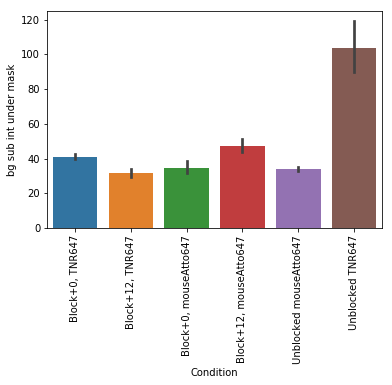

In [127]:
var="bg sub int under mask"
#var="intensity"
#var="int under mask"

sns.barplot(x="Condition",y=var,data=df2)
plt.xticks(rotation=90)

In [116]:

means={"expname":[],"Condition":[],"intensity":[]}

df2read=df2
           #& (df2["expname"]!="20181113_NCAN_analyse")]


for exp in df2read["expno"].unique():
    dfcalc=df2read[df2read["expno"]==exp]
    dfcalc=dfcalc.reset_index()
    for condition in dfcalc["Condition"].unique():
        dfcalc_cond=dfcalc[dfcalc["Condition"]==condition]
        means["expname"].append(exp)
        means["Condition"].append(condition)
        means["intensity"].append(dfcalc_cond[var].mean())
        means
    
    
    
dfmeans=pd.DataFrame(means)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

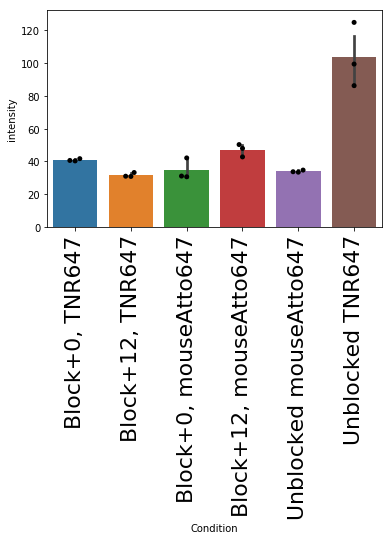

In [117]:
sns.barplot(data=dfmeans,x="Condition",y="intensity")
sns.swarmplot(data=dfmeans,x="Condition",y="intensity",color='black')
plt.xticks(rotation=90,fontsize=22)

## make df with intensity of each exp normalised to background

In [154]:
df2.columns

Index(['filename', 'exp', 'Manual mask from matlab GUI', 'intensity',
       'int under mask', 'bg sub int under mask', 'bg sub int unmasked',
       'Blocked or not', 'Time', 'TNR or secondary', 'expno', 'Condition'],
      dtype='object')

In [174]:
var="bg sub int under mask"
df_norms={"expname":[],"intensity norm2bg":[],"condition":[]}
for exp in df2["expno"].unique():
    dfexp=df2[df2["expno"]==exp]
    
    intensity_attounblocked=dfexp[dfexp["Condition"]=="Unblocked mouseAtto647"][var].mean()
    
    df_norms["intensity norm2bg"].append(1)
    df_norms["condition"].append("Background (atto647 mouse)")
    df_norms["expname"].append(exp)
    
    intensity_unblocked=dfexp[dfexp["Condition"]=="Unblocked TNR647"][var].mean()/intensity_attounblocked
    df_norms["intensity norm2bg"].append(intensity_unblocked)
    df_norms["expname"].append(exp)
    df_norms["condition"].append("Unblocked TNR647")
    
    intensity_block0=dfexp[dfexp["Condition"]=="Block+0, TNR647"][var].mean()/intensity_attounblocked
    df_norms["intensity norm2bg"].append(intensity_block0)
    df_norms["expname"].append(exp)
    df_norms["condition"].append("Block+0, TNR647")
    
    intensity_block12=dfexp[dfexp["Condition"]=="Block+12, TNR647"][var].mean()/intensity_attounblocked
    df_norms["intensity norm2bg"].append(intensity_block12)
    df_norms["expname"].append(exp)
    df_norms["condition"].append("Block+12, TNR647")
    
df_norms=pd.DataFrame(df_norms)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

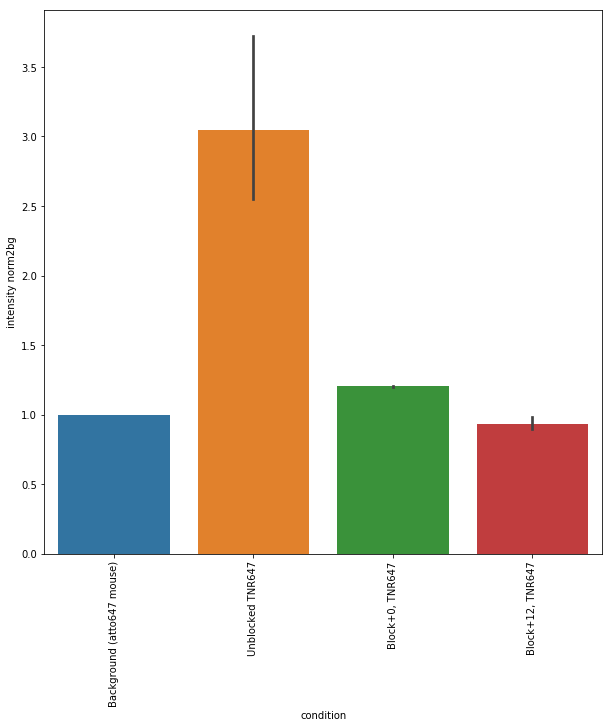

In [175]:
plt.figure(figsize=(10,10))
sns.barplot(data=df_norms,x="condition",y="intensity norm2bg")
plt.xticks(rotation=90)

In [173]:
intensity_unblocked

intensity                0.172499
int under mask           0.183531
bg sub int under mask    2.857118
bg sub int unmasked      2.121557
dtype: float64